In [3]:
import pandas as pd
import os
from Bio import Entrez, SeqIO
import tqdm
from collections import Counter
import numpy as np
from scipy.stats import multinomial
import numpy as np
import matplotlib.pyplot as plt


## Exploring LLR Distributions and Threshold Selection

This analysis explores the distribution of per-sequence sum log-likelihood ratios (LLRs) associated with molnupiravir-induced mutational signatures. A range of LLR thresholds are evaluated to assess their ability to discriminate between MOV-associated and non-MOV sequence populations, using Australia and France as representative examples, respectively.
By comparing how the number and proportion of sequences exceeding each threshold change across these two countries, we identify threshold values that balance retention of signal in MOV-associated sequences with suppression of background signal in non-MOV sequences. 


In [5]:
df= pd.read_csv("/Users/reem/Mov/final_llrs_with_sum.tsv", sep="\t")

In [83]:
df['seqName'] = df['seqName'].str.split("|").str[0]
df['seqName'].head()

0                 hCoV-19/USA/CA-CDPH-500004296/2021
1                     hCoV-19/Spain/CL-COV01948/2021
2                 hCoV-19/USA/OR-OHSU-213401246/2021
3              hCoV-19/Germany/SL-RKI-I-1077947/2022
4    hCoV-19/USA/MA-CDCBI-CRSP_HGQQM7RZS5PYBHGU/2022
Name: seqName, dtype: object

In [6]:
df.head()

,Unnamed: 0,seqName,privateNucMutations.unlabeledSubstitutions,subs,Counts,context,spectrum,G>A_counts,A>G_counts,C>T_counts,...,C>Tproportions,T>Cproportions,LLR,G>A_llr,A>G_llr,C>T_llr,T>C_llr,sum_llrs,country,year
0,0,hCoV-19/USA/CA-CDPH-500004296/2021|2021-07-17|...,"A2396G,T13832C,C25665T,C27673T","A>G,T>C,C>T,C>T","{'A>G': 1, 'T>C': 1, 'C>T': 2}","CAC,TTA,ACT,TCA","C[A>G]C,T[T>C]A,A[C>T]T,T[C>T]A",{},{'C[A>G]C': 1},"{'A[C>T]T': 1, 'T[C>T]A': 1}",...,"{'A[C>T]T': 0.5, 'T[C>T]A': 0.5}",{'T[T>C]A': 1.0},0.133011,NaN,0.004225,0.069622,0.156313,0.363170,USA,2021
1,1,hCoV-19/Spain/CL-COV01948/2021|2021-04-08|2021...,"C4901T,C6525T,A12162G,C12781T,G16558T,C23415T,...","C>T,C>T,A>G,C>T,G>T,C>T,G>T,C>T","{'C>T': 5, 'A>G': 1, 'G>T': 2}","CCT,ACA,CAG,ACA,TGC,ACA,TGG,CCA","C[C>T]T,A[C>T]A,C[A>G]G,A[C>T]A,T[G>T]C,A[C>T]...",{},{'C[A>G]G': 1},"{'A[C>T]A': 3, 'C[C>T]T': 1, 'C[C>T]A': 1}",...,"{'C[C>T]T': 0.2, 'A[C>T]A': 0.6, 'C[C>T]A': 0.2}",{},-1.049009,NaN,0.319879,0.480353,NaN,-0.248777,Spain,2021
2,2,hCoV-19/USA/OR-OHSU-213401246/2021|2021-10-27|...,"C4084T,T7092C,A13956G,C14585T,A20425G,C21897T,...","C>T,T>C,A>G,C>T,A>G,C>T,C>T,C>T","{'C>T': 5, 'T>C': 1, 'A>G': 2}","ACA,GTC,TAC,GCT,TAT,TCG,TCT,ACA","A[C>T]A,G[T>C]C,T[A>G]C,G[C>T]T,T[A>G]T,T[C>T]...",{},"{'T[A>G]C': 1, 'T[A>G]T': 1}","{'A[C>T]A': 2, 'G[C>T]T': 1, 'T[C>T]G': 1, 'T[...",...,"{'A[C>T]A': 0.4, 'G[C>T]T': 0.2, 'T[C>T]G': 0....",{'G[T>C]C': 1.0},1.231103,NaN,-1.811061,-0.505227,-0.447496,-1.532681,USA,2021
3,3,hCoV-19/Germany/SL-RKI-I-1077947/2022|2022-12-...,A29188G,A>G,{'A>G': 1},CAC,C[A>G]C,{},{'C[A>G]C': 1},{},...,{},{},-0.210447,NaN,0.004225,NaN,NaN,-0.206223,Germany,2022
4,4,hCoV-19/USA/MA-CDCBI-CRSP_HGQQM7RZS5PYBHGU/202...,"C21595T,G21777T","C>T,G>T","{'C>T': 1, 'G>T': 1}","TCT,GGG","T[C>T]T,G[G>T]G",{},{},{'T[C>T]T': 1},...,{'T[C>T]T': 1.0},{},-1.073550,NaN,NaN,-0.489601,NaN,-1.563151,USA,2022


In [20]:
df['sum_llrs']=df[['LLR','G>A_llr','A>G_llr','C>T_llr','T>C_llr']].sum(axis=1,skipna=True)
#df['sum_llrs'].head()


print(df['sum_llrs'].min())
print(df['sum_llrs'].max())
print(df['sum_llrs'].mean())
print(df['sum_llrs'].describe())


-6287.242208775208
53.621186859056515
-1.3153611359911954
count    1.685715e+07
mean    -1.315361e+00
std      7.441284e+00
min     -6.287242e+03
25%     -2.290032e+00
50%     -7.957429e-01
75%      1.331973e-01
max      5.362119e+01
Name: sum_llrs, dtype: float64


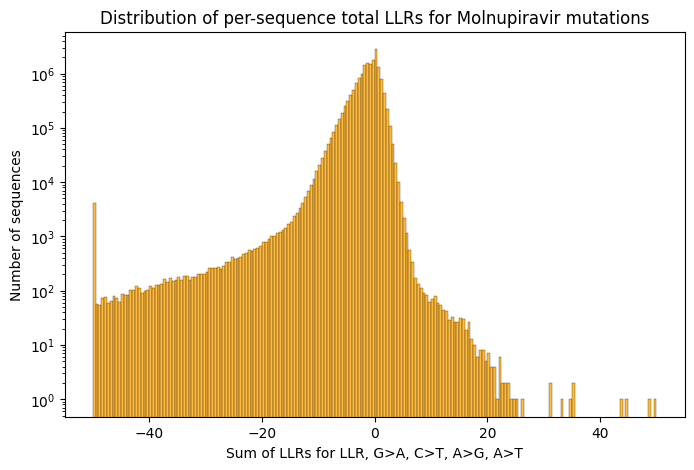

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.histplot(df["sum_llrs"].clip(-50,50), bins=200, color='orange')
#plt.xlim(-30, 60)
plt.yscale('log')
plt.title("Distribution of per-sequence total LLRs for Molnupiravir mutations")
plt.xlabel("Sum of LLRs for LLR, G>A, C>T, A>G, T>C")
plt.ylabel("Number of sequences")
plt.show()

In [28]:
len(df)

16857152

In [ ]:

df['country'] = df['seqName'].str.split("/").str[1]
df['year'] = df['seqName'].str.split("/").str[3]
df = df[['seqName','LLR','G>A_llr','C>T_llr','A>G_llr','T>C_llr','sum_llrs','country', 'year',]]

# print(df['country'].value_counts())
# print(df['year'].value_counts())

In [42]:
thresholds = [2,5,6,7,8,10,15,20]
countries = ['Australia','France']
for t in thresholds:
    for country in countries:
        count = len(df[(df['sum_llrs'] > t) & (df['seqName'].str.contains(f"/{country}/"))])
        print(f"Number of sequences from {country} with sum_llrs > {t}: {count}")

             

Number of sequences from Australia with sum_llrs > 2: 6620
Number of sequences from France with sum_llrs > 2: 14402
Number of sequences from Australia with sum_llrs > 5: 689
Number of sequences from France with sum_llrs > 5: 142
Number of sequences from Australia with sum_llrs > 6: 538
Number of sequences from France with sum_llrs > 6: 30
Number of sequences from Australia with sum_llrs > 7: 430
Number of sequences from France with sum_llrs > 7: 6
Number of sequences from Australia with sum_llrs > 8: 358
Number of sequences from France with sum_llrs > 8: 3
Number of sequences from Australia with sum_llrs > 10: 243
Number of sequences from France with sum_llrs > 10: 0
Number of sequences from Australia with sum_llrs > 15: 77
Number of sequences from France with sum_llrs > 15: 0
Number of sequences from Australia with sum_llrs > 20: 21
Number of sequences from France with sum_llrs > 20: 0


In [ ]:
thresholds = [2,5,6,7,8,10,15,20]
for t in thresholds:
    
    for country in countries:
        count = len(df[(df['sum_llrs'] > t) & (df['seqName'].str.contains(f"/{country}/"))])
        print(f"Number of sequences from {country} with sum_llrs > {t}: {count}")


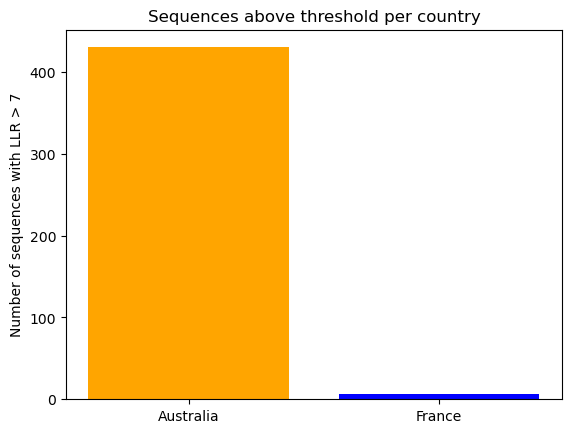

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define threshold
t = 7

# Count sequences above threshold for each country
countries = ['Australia', 'France']
counts = [
    (df[df['country']=='Australia']['sum_llrs'] > t).sum(),
    (df[df['country']=='France']['sum_llrs'] > t).sum()
]

# Create bar plot
plt.bar(countries, counts, color=['orange', 'blue'])
plt.ylabel("Number of sequences with LLR > {}".format(t))
plt.title("Sequences above threshold per country")
plt.show()

In [8]:
import matplotlib.pyplot as plt

thresholds = range(2, 20, 1)
australia_counts = [(df[df['country']=='Australia']['sum_llrs'] > t).sum() for t in thresholds]
france_counts = [(df[df['country']=='France']['sum_llrs'] > t).sum() for t in thresholds]



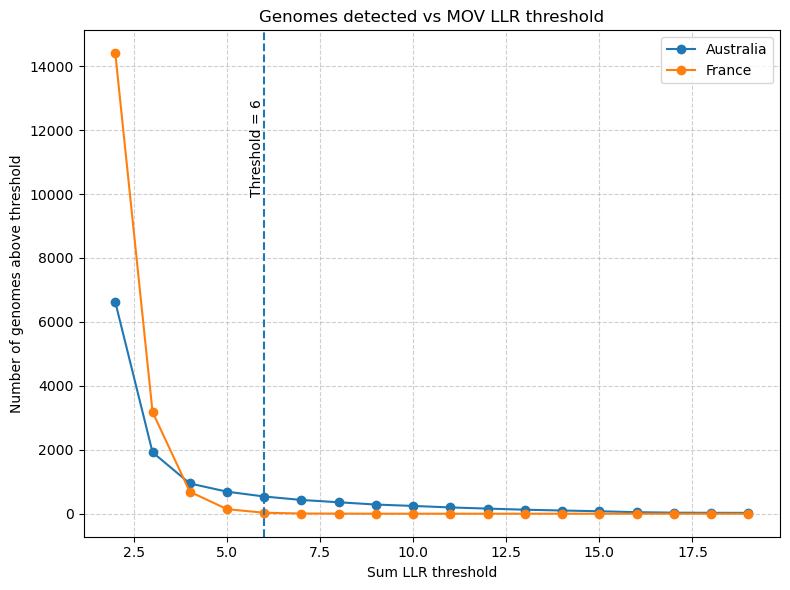

In [13]:
import matplotlib.pyplot as plt

# thresholds: list/array of LLR thresholds (same order as counts)
# australia_counts, france_counts: counts above each threshold

plt.figure(figsize=(8, 6))

plt.plot(thresholds, australia_counts, marker="o", label="Australia")
plt.plot(thresholds, france_counts, marker="o", label="France")

# Highlight threshold = 6
plt.axvline(6, linestyle="--")
plt.text(6, max(max(australia_counts), max(france_counts))*0.9, "Threshold = 6", rotation=90, va="top", ha="right")

plt.xlabel("Sum LLR threshold")
plt.ylabel("Number of genomes above threshold")
plt.title("Genomes detected vs MOV LLR threshold")

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()





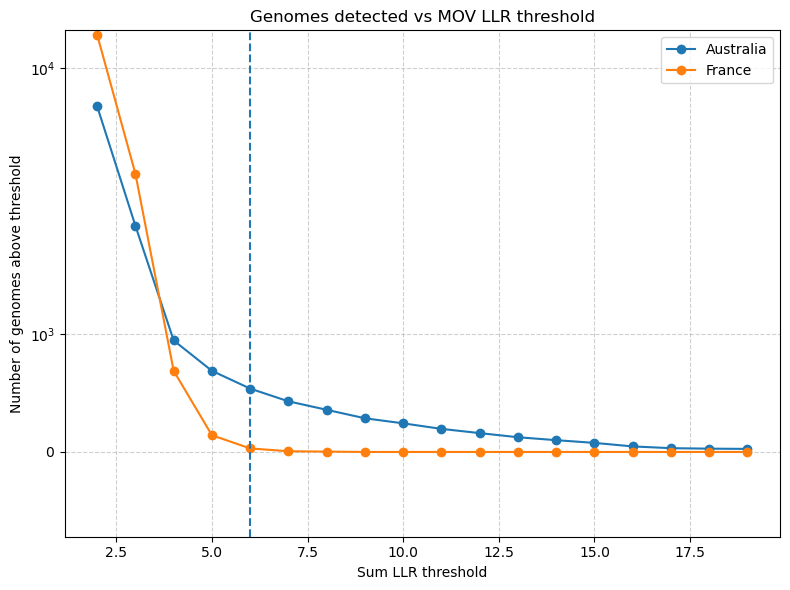

In [ ]:
# Using symlog scale for y-axis to show the full range of counts closer to 0.
plt.figure(figsize=(8, 6))

plt.plot(thresholds, australia_counts, marker="o", label="Australia")
plt.plot(thresholds, france_counts, marker="o", label="France")

plt.axvline(6, linestyle="--")

plt.xlabel("Sum LLR threshold")
plt.ylabel("Number of genomes above threshold")
plt.title("Genomes detected vs MOV LLR threshold")

# 🔑 key line
plt.yscale("symlog", linthresh=2000)

plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
